# Keras MNIST classifier with _distributed_ random-search hyper-parameter optimization and _interactive widgets_

In this notebook we demonstrate distributed hyper-parameter optimization (HPO) with an _interactive widget_ which shows a live table of model results and training objective plots for a selected model row.

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import
import os
from functools import partial

# External imports
import ipyparallel as ipp
import numpy as np
import matplotlib.pyplot as plt
import keras

# Local imports
from mnist import load_data
from hpo_widgets import ModelPlot, ParamSpanWidget

/global/cscratch1/sd/sfarrell/conda/isc-ihpc/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Connect to cluster

Here we use a shell command to query the slurm job ID running our cluster, then we connect using the corresponding cluster ID.

In [2]:
%%bash
squeue -u sfarrell

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          13958933 interacti       sh sfarrell  R      37:17      8 nid00[047-052,124,153]


In [3]:
# Cluster ID taken from job ID above
job_id = 13958933
cluster_id = 'cori_{}'.format(job_id)

# Use default profile
c = ipp.Client(timeout=60, cluster_id=cluster_id)
print('Worker IDs:', c.ids)

Worker IDs: [0, 1, 2, 3, 4, 5, 6, 7]


## Load the data

In [4]:
x_train, y_train, x_test, y_test = load_data()

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10)
y_test shape: (10000, 10)


## Configure the tasks

In [5]:
# Temporarily making things reproducible for development
np.random.seed(0)

# Define the hyper-parameter search points
n_hpo_trials = 8 #64
grid_h1 = np.random.choice([4, 8, 16, 32, 64], size=n_hpo_trials)
grid_h2 = np.random.choice([4, 8, 16, 32, 64], size=n_hpo_trials)
grid_h3 = np.random.choice([8, 16, 32, 64, 128], size=n_hpo_trials)
grid_dropout = np.random.rand(n_hpo_trials)
grid_optimizer = np.random.choice(['Adadelta', 'Adam', 'Nadam'], size=n_hpo_trials)

# Training config
batch_size = 128
n_epochs = 16
valid_frac = 0.17
checkpoint_dir = '/global/cscratch1/sd/sfarrell/cori-interactive-dl/mnist_hpo_%i' % job_id
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_dir = os.path.join(os.environ['SCRATCH'],
                              'cori-interactive-dl/mnist_hpo_%i' % job_id)
os.makedirs(checkpoint_dir, exist_ok=True)

## Run the trainings

In [6]:
def build_and_train(valid_frac, batch_size, n_epochs,
                    h1, h2, h3, dropout, optimizer, verbose=0,
                    checkpoint_file=None):
    """Run training for one set of hyper-parameters"""
    import keras
    from mnist import build_model, load_data
    from mlextras import configure_session, IPyParallelLogger
    # Load the data
    x_train, y_train, _, _ = load_data()
    # Thread settings
    keras.backend.set_session(configure_session())
    # Build the model
    model = build_model(h1=h1, h2=h2, h3=h3,
                        dropout=dropout, optimizer=optimizer)
    callbacks = []
    if checkpoint_file is not None:
        callbacks.append(keras.callbacks.ModelCheckpoint(checkpoint_file))
    callbacks.append(IPyParallelLogger())
    # Train the model
    history = model.fit(x_train, y_train,
                        validation_split=valid_frac,
                        batch_size=batch_size, epochs=n_epochs,
                        verbose=verbose, callbacks=callbacks)
    return history.history

In [7]:
train_func = partial(build_and_train, valid_frac=valid_frac,
                     batch_size=batch_size, n_epochs=n_epochs,
                     verbose=2)

plot_func = partial(
    ModelPlot,
    y=['loss', 'acc', 'val_loss', 'val_acc'],
    xlim=[0, n_epochs],
    xlabel='epochs',
    ylabel='training metrics'
)

hpo_params = dict(
    h1=grid_h1,
    h2=grid_h2,
    h3=grid_h3,
    dropout=grid_dropout,
    optimizer=grid_optimizer
)
psw = ParamSpanWidget(
    compute_func=train_func, 
    vis_func=plot_func, 
    params=hpo_params,
    ipp_cluster_id=cluster_id
)

psw.submit_computations()
psw

ParamSpanWidget(children=(Output(layout=Layout(border='1px solid', height='600px', overflow_x='scroll', overfl…

### Broken from here

In [8]:
results = psw.model_runs

AttributeError: 'ParamSpanWidget' object has no attribute 'model_runs'

In [ ]:
print('Tasks completed: %i / %i' % (np.sum([ar.ready() for ar in results]), len(results)))

In [ ]:
ar = results[0]
ar.metadata

In [20]:
histories = [ar.get() for ar in results]

## Model selection and evaluation

In [21]:
last_scores = np.array([h['val_acc'][-1] for h in histories])
best_scores = np.array([max(h['val_acc']) for h in histories])

### Best model

In [22]:
%matplotlib notebook

Hyperparameters: trial 4 hidden 32-16-64 dropout 0.118 opt Adadelta
  Last validation accuracy 0.9895
  Best validation accuracy 0.9905


<IPython.core.display.Javascript object>


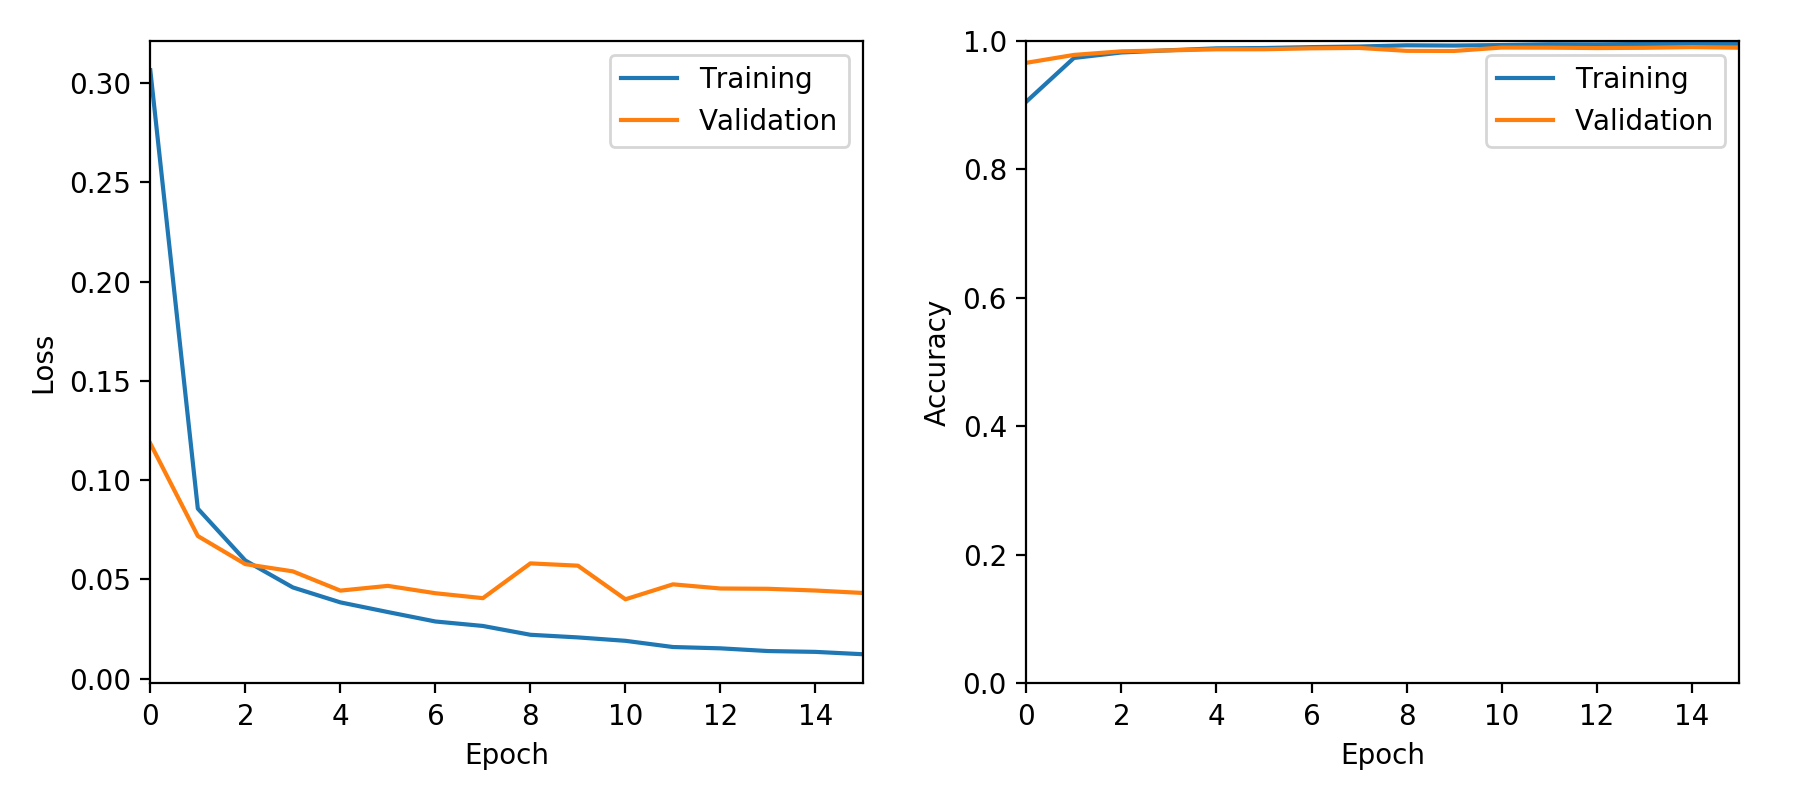

In [23]:
# Find the best in terms of final validation set accuracy
i = best_scores.argmax()
h = histories[i]

print('Hyperparameters: trial %i hidden %i-%i-%i dropout %.3f opt %s' %
      (i, grid_h1[i], grid_h2[i], grid_h3[i], grid_dropout[i], grid_optimizer[i]))
print('  Last validation accuracy %.4f' % last_scores[i])
print('  Best validation accuracy %.4f' % best_scores[i])

plt.figure(figsize=(9,4))

# Loss
plt.subplot(121)
plt.plot(h['loss'], label='Training')
plt.plot(h['val_loss'], label='Validation')
plt.xlim(xmin=0, xmax=len(h['loss'])-1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

# Accuracy
plt.subplot(122)
plt.plot(h['acc'], label='Training')
plt.plot(h['val_acc'], label='Validation')
plt.xlim(xmin=0, xmax=len(h['loss'])-1)
plt.ylim((0, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.tight_layout()

### Worst model

Hyperparameters: trial 0 hidden 64-64-16 dropout 0.979 opt Nadam
  Last validation accuracy 0.1066
  Best validation accuracy 0.1066


<IPython.core.display.Javascript object>


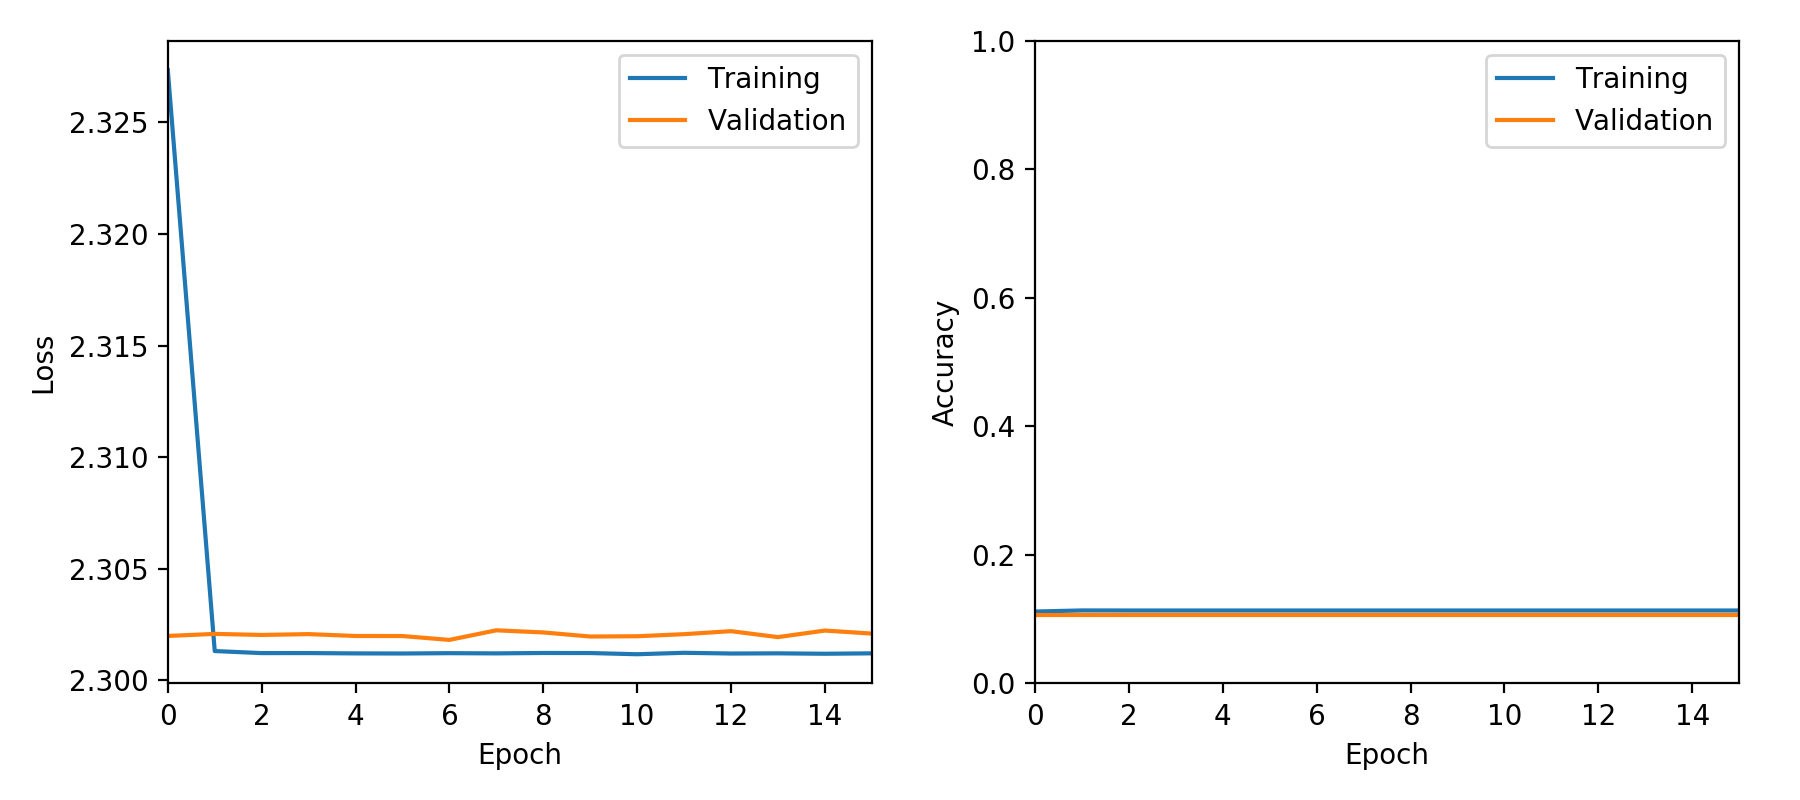

In [24]:
# Find the best in terms of final validation set accuracy
i = best_scores.argmin()
h = histories[i]

print('Hyperparameters: trial %i hidden %i-%i-%i dropout %.3f opt %s' %
      (i, grid_h1[i], grid_h2[i], grid_h3[i], grid_dropout[i], grid_optimizer[i]))
print('  Last validation accuracy %.4f' % last_scores[i])
print('  Best validation accuracy %.4f' % best_scores[i])

plt.figure(figsize=(9,4))

# Loss
plt.subplot(121)
plt.plot(h['loss'], label='Training')
plt.plot(h['val_loss'], label='Validation')
plt.xlim(xmin=0, xmax=len(h['loss'])-1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0)

# Accuracy
plt.subplot(122)
plt.plot(h['acc'], label='Training')
plt.plot(h['val_acc'], label='Validation')
plt.xlim(xmin=0, xmax=len(h['loss'])-1)
plt.ylim((0, 1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc=0)

plt.tight_layout()

### Test set evaluation

Here we load the best selected model and evaluate final performance on the test set.

In [ ]:
i = best_scores.argmax()
model_file = os.path.join(checkpoint_dir, 'model_%i.h5' % i)
model = keras.models.load_model(model_file)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print('Test loss: %.4f' % test_loss)
print('Test accuracy: %.4f' % test_acc)